3.0


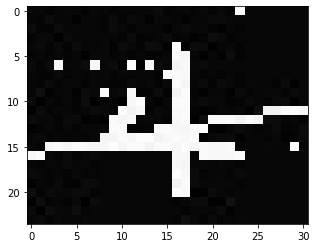

In [1]:
import cv2
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

encoding = '123456789'
labels_file = 'labels.csv'

img_list = []
label_list = []

with open(labels_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    fieldnames = reader.fieldnames
    for row in reader:
        img_list.append(row[fieldnames[0]])
        label_list.append(encoding.index(row[fieldnames[1]]))
    
items=[]
for i in range(len(img_list)):
    items.append(i)
X = []
y = []
for i in random.sample(items,len(img_list)):
    img = cv2.imread(img_list[i], 0)
    img = tf.keras.preprocessing.image.img_to_array(img)
    X.append(img)
    y.append(label_list[i])
    
X = 1 - np.array(X).astype(float)/255 # invert and scale
y = np.array(y).astype(float)

plt.imshow(X[0], cmap=plt.get_cmap('gray'))
print(y[0])

In [2]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24, 31, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(9, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 29, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 29, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 12, 64)         18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 12, 64)         256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 4, 128)         7

In [3]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.9,
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
batch_size = 32
epochs = 80

In [4]:
history = model.fit(
    X, 
    y,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/80
499/499 [==============================] - 5s 10ms/step - loss: 0.8618 - sparse_categorical_accuracy: 0.7429 - val_loss: 2.3786 - val_sparse_categorical_accuracy: 0.4370
Epoch 2/80
499/499 [==============================] - 4s 8ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.0198 - val_sparse_categorical_accuracy: 0.9952
Epoch 3/80
499/499 [==============================] - 4s 9ms/step - loss: 0.0422 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.0192 - val_sparse_categorical_accuracy: 0.9935
Epoch 4/80
499/499 [==============================] - 4s 9ms/step - loss: 0.0377 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.0215 - val_sparse_categorical_accuracy: 0.9955
Epoch 5/80
499/499 [==============================] - 4s 9ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0212 - val_sparse_categorical_accuracy: 0.9960
Epoch 6/80
499/499 [==============================] - 4s 8ms/step - loss: 0.0193 - sparse_categoric

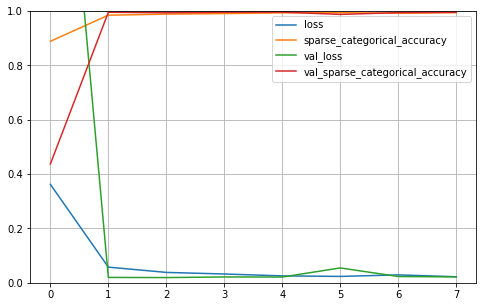

In [5]:
import pandas as pd
def plot_learning_curves(history):
    df = pd.DataFrame(history.history)
    df.plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

array([[1.3571890e-16, 1.0000000e+00, 2.1125309e-15, 2.8066321e-17,
        4.9996202e-18, 8.7868667e-18, 1.2818274e-16, 1.5460787e-16,
        1.4158070e-12]], dtype=float32)

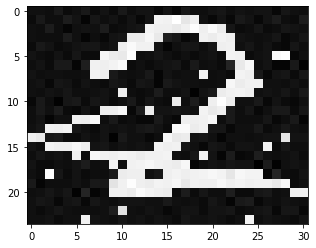

In [6]:
out = model.predict(np.expand_dims(X[5], 0))
plt.imshow(X[5], cmap=plt.get_cmap('gray'))
out

In [7]:
model.save('model.h5')

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'model.json')